# Assignment Module 7 Logistic Regression

### Group Members:
- Julian
- Omar M. Hussein
- Eli weiss

## Introduction

The banking industry in the USA is highly regulated. Banks are required to adhere to strict guidelines regarding the management of customer deposits. In this project we are going to attempt to logistic regression models that perform predictions on whether the an indivisual's loan will be accepted or rejected. We will also exhibt the statistically significant features that contribute the most to whether or not a loan is going to be accepted.


## Data Profiling

The data set is sourced from the Federal Reserve Bank of Boston. A brief overview of the content of the data set can be found here: <br>
https://vincentarelbundock.github.io/Rdatasets/doc/Ecdat/Hdma.html

The data set is comprised of 2,381 observations of 1 response/dependent variable (which indicates whether or not a mortgage application was denied) and 12 explanatory/independent variables.

- __dir:__ debt payments to total income ratio
- __hir:__ housing expenses to income ratio
- __lvr:__ ratio of size of loan to assessed value of property
- __ccs:__ consumer credit score from 1 to 6 (a low value being a good score)
- __mcs:__ mortgage credit score from 1 to 4 (a low value being a good score)
- __pbcr:__ public bad credit record ?
- __dmi:__ denied mortgage insurance ?
- __self:__ self employed ?
- __single:__ is the applicant single ?
- __uria:__ 1989 Massachusetts unemployment rate in the applicant's industry
- __condominium:__ is unit a condominium ? (was called comdominiom in version 0.2-9 and earlier versions of the package)
- __black:__ is the applicant black ?
- __deny (response):__ mortgage application denied ?

In [1]:
#create a list of meaningful column names
columns=['debt_pymt_income_ratio', 'house_expen_income_ratio', 'loan_size_prop_value_ratio', 'cons_cred_score',
         'mort_cred_score', 'bad_credit_record','denied_mort_insur','self_emp', 'single', 'unemp_rate_app_industry',
         'unit_condo','black','deny']

In [2]:
# split categorical and numeric features, so we can deal with them seperately.

# Categorical
categorical = ['bad_credit_record', 'denied_mort_insur', 'self_emp', 'single', 'unit_condo', 'black']

# Numerical
numeric = ['debt_pymt_income_ratio', 'house_expen_income_ratio', 'loan_size_prop_value_ratio', 'cons_cred_score',
           'mort_cred_score', 'unemp_rate_app_industry']

## Exploratory Data Analysis

### Logistic Regression Assumptions
- Binary logistic regression requires the dependent variable to be binary.
- For a binary regression, the factor level 1 of the dependent variable should represent the desired outcome.
- Only the meaningful variables should be included.
- The independent variables should be independent of each other. That is, the model should have little or no multicollinearity.
- The independent variables are linearly related to the log odds.
- Logistic regression requires quite large sample sizes.

Keeping the above assumptions in mind, let’s look at our dataset.

First we will read the data into python using pandas read csv function. We will replace the column names to the ones we define to be more meaningful for analysis purposes. Then we will look for missing and/or invalid data values and perform an exploratory data analysis on our dataset to determine what data need to be prepared for a future machine learning model.

In [3]:
# importing libraries needed
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import probplot
from pandas.plotting import scatter_matrix
import missingno as msno
from IPython.display import Markdown, display
import statsmodels.api as sm
from statsmodels.tools import add_constant as add_constant
import statsmodels.formula.api as smf

# styling matplotlib graphs
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (8,4)

#loading the data from github repo
df = pd.read_csv("https://raw.githubusercontent.com/OMS1996/DAV-6150-Data-Science/master/Data/M7_Data.csv")

#The head.
df.head(3)

,Unnamed: 0,dir,hir,lvr,ccs,mcs,pbcr,dmi,self,single,uria,comdominiom,black,deny
0,1,0.221,0.221,0.800000,5.0,2.0,no,no,no,no,3.9,0,no,no
1,2,0.265,0.265,0.921875,2.0,2.0,no,no,no,yes,3.2,0,no,no
2,3,0.372,0.248,0.920398,1.0,2.0,no,no,no,no,3.2,0,no,no


In [4]:
#exclude first column and rename the rest
df = df.iloc[:,1:]
df.columns = columns

#sanity check
df.head(2)

,debt_pymt_income_ratio,house_expen_income_ratio,loan_size_prop_value_ratio,cons_cred_score,mort_cred_score,bad_credit_record,denied_mort_insur,self_emp,single,unemp_rate_app_industry,unit_condo,black,deny
0,0.221,0.221,0.800000,5.0,2.0,no,no,no,no,3.9,0,no,no
1,0.265,0.265,0.921875,2.0,2.0,no,no,no,yes,3.2,0,no,no


In [5]:
# Replacing the yes and no with binary values suitable for analysis.
df.deny.replace(["no", "yes"], [0, 1], inplace = True)

Here we will look at the data types and check those records with null values.

In [6]:
#checking df info, including column data types, and if any null values
df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   debt_pymt_income_ratio      2381 non-null   float64
 1   house_expen_income_ratio    2381 non-null   float64
 2   loan_size_prop_value_ratio  2381 non-null   float64
 3   cons_cred_score             2381 non-null   float64
 4   mort_cred_score             2381 non-null   float64
 5   bad_credit_record           2380 non-null   object 
 6   denied_mort_insur           2381 non-null   object 
 7   self_emp                    2380 non-null   object 
 8   single                      2381 non-null   object 
 9   unemp_rate_app_industry     2381 non-null   float64
 10  unit_condo                  2381 non-null   int64  
 11  black                       2381 non-null   object 
 12  deny                        2381 non-null   int64  
dtypes: float64(6), int64(2), object(5

We can see that there is only 1 record with missing values for 'bad_credit_record' and 1 record for 'self_emp', we will check to see that record/s. Here we also see that the number of observations is large enough to perform logistic regression.

In [7]:
#chequing records with null values.
df[df.isnull().any(axis = 1)]

,debt_pymt_income_ratio,house_expen_income_ratio,loan_size_prop_value_ratio,cons_cred_score,mort_cred_score,bad_credit_record,denied_mort_insur,self_emp,single,unemp_rate_app_industry,unit_condo,black,deny
2380,0.330814,0.255346,0.700783,2.116387,1.721008,NaN,no,NaN,yes,3.774496,0,no,0


Its only one record, among over 2381 observations, hence we can safely exclude it from our analysis.

In [8]:
#exclude the only record with null values
df = df.dropna()
df.shape

(2380, 13)

Now we will perform an exploration of the response distribution, getting the value_counts to see its distribution and then each explanatory variable association with the response. 

0    2095
1     285
Name: deny, dtype: int64
percentage of no mortage deny is 88.02521008403362
percentage of deny 11.974789915966387


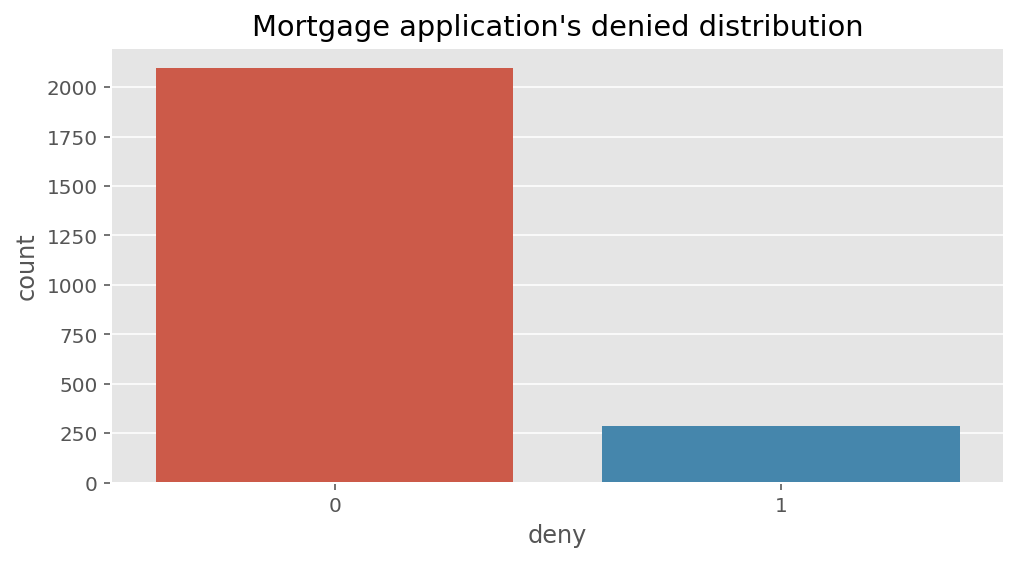

In [9]:
#print value counts
print(df.deny.value_counts())

#get separate counts for each response value to see %
count_no_denied = len(df[df['deny'] == 0])
count_denied = len(df[df['deny'] == 1])

pct_of_no_deny = count_no_denied/(count_no_denied+count_denied)
print("percentage of no mortage deny is", pct_of_no_deny*100)
pct_of_deny = count_denied/(count_no_denied+count_denied)
print("percentage of deny", pct_of_deny*100)
sns.countplot(x = 'deny', data = df).set_title("Mortgage application's denied distribution")
plt.show();

Our classes are imbalanced, and the ratio of denied mortage application to no-denied instances is 88:12. By simply predicting "Do not deny" for each applicant we could achieve a training model accuracy of 88%. This metric is referred to as the null error rate. Before we go ahead to balance the classes, let’s do some more exploration.

### EDA on Numeric Features

In [10]:
df.groupby('deny').mean()

,debt_pymt_income_ratio,house_expen_income_ratio,loan_size_prop_value_ratio,cons_cred_score,mort_cred_score,unemp_rate_app_industry,unit_condo
deny,,,,,,,
0,0.322929,0.250603,0.727083,1.955131,1.699284,3.741909,0.281623
1,0.388771,0.290212,0.816379,3.301754,1.880702,4.014035,0.336842


We can see that on average, people that get their mortgage application denied have higher:
- debt payments to total income ratio, make sense
- housing expenses to income ratio, make sense
- ratio of size of loan to assessed value of property
- consumer credit score, make sense the larger the score get worse
- mortgage credit score, make sense the larger the score get worse
- 1989 Massachusetts unemployment rate in the applicant's industry

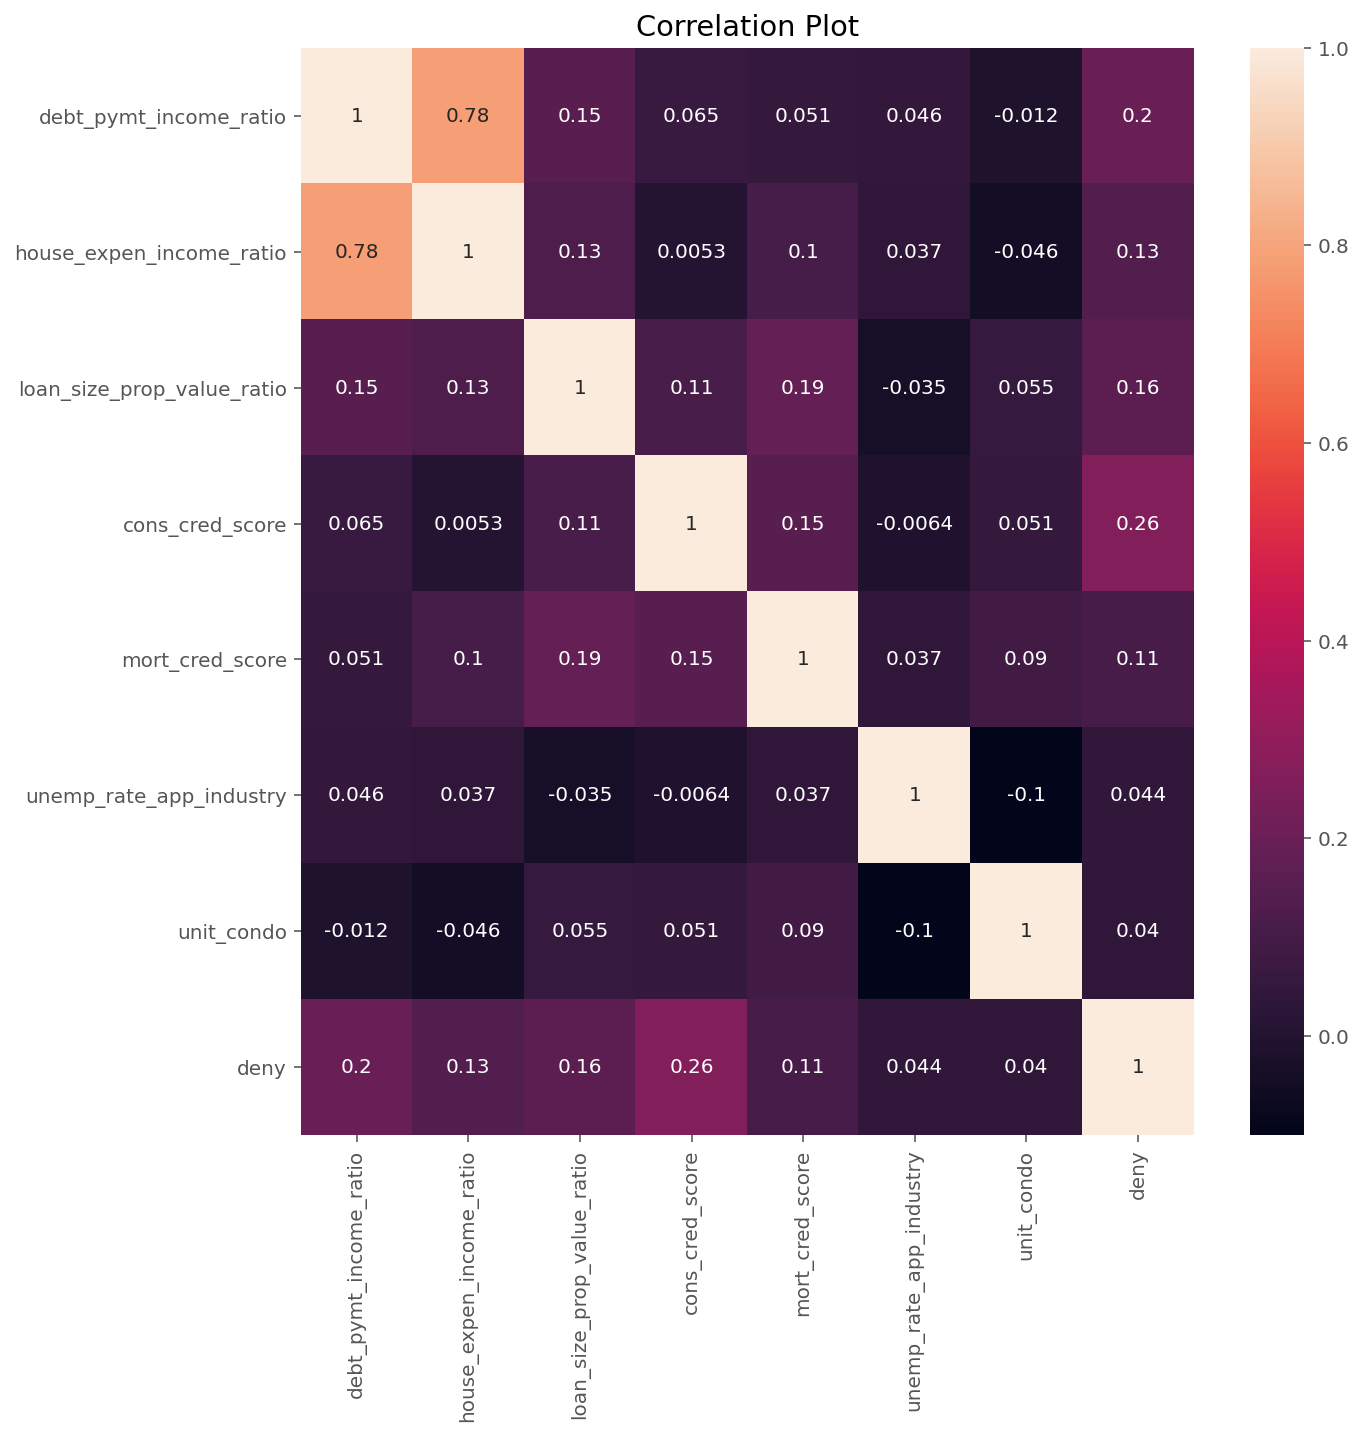

In [11]:
# initial correlation
cor = df.corr()
plt.figure(figsize=(10,10))
plt.title("Correlation Plot")
sns.heatmap(cor,annot=True)
plt.show();

In [12]:
numeric

['debt_pymt_income_ratio',
 'house_expen_income_ratio',
 'loan_size_prop_value_ratio',
 'cons_cred_score',
 'mort_cred_score',
 'unemp_rate_app_industry']

We can see that 'debt_pymt_income_ratio' and 'house_expen_income_ratio' show a correlation of 0.78 suggesting that there might be some collinearity between both variables.

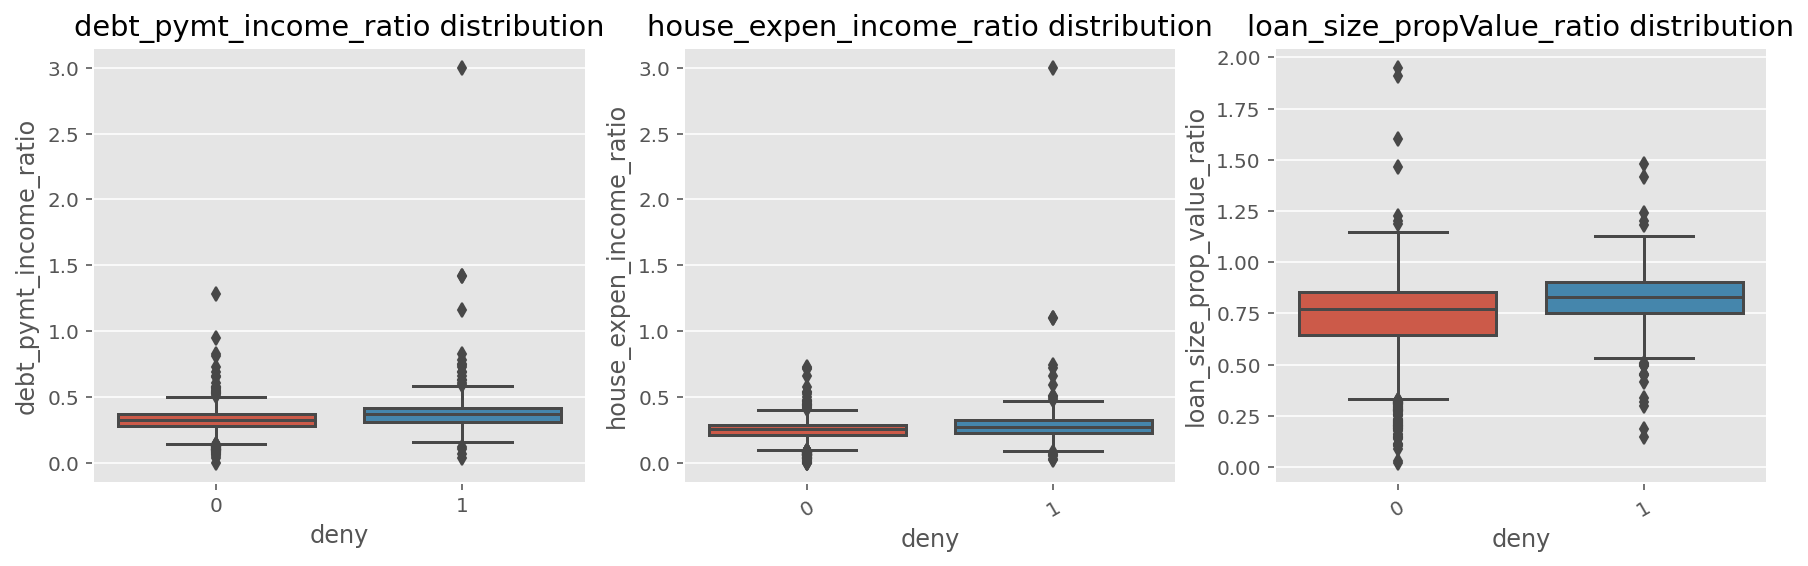

In [13]:
#showing boxplots
fig = plt.figure(figsize=(15,4))
plt.subplot(1, 3, 1)
sns.boxplot(x="deny", y="debt_pymt_income_ratio", data=df)
plt.title("debt_pymt_income_ratio distribution");

plt.subplot(1, 3, 2)
ax=sns.boxplot(x="deny", y="house_expen_income_ratio", data=df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.title("house_expen_income_ratio distribution");

plt.subplot(1, 3, 3)
ax=sns.boxplot(x="deny", y="loan_size_prop_value_ratio", data=df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.title("loan_size_propValue_ratio distribution");

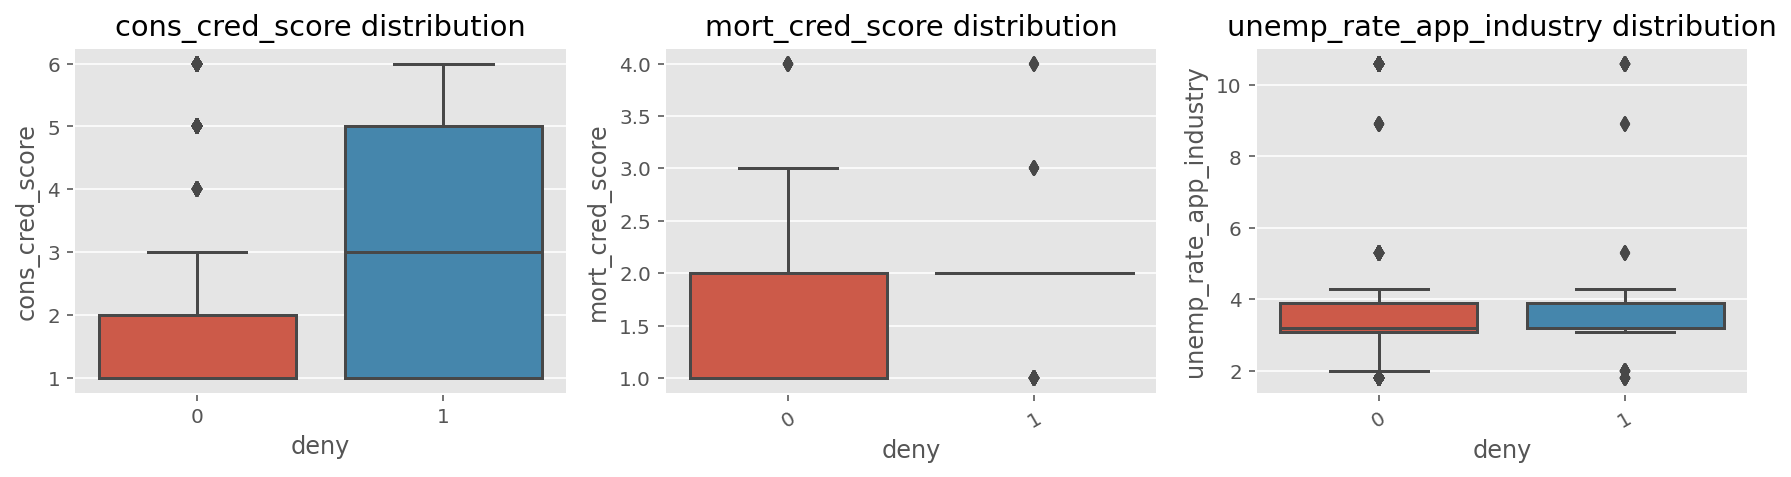

In [14]:
fig = plt.figure(figsize=(15,7))
plt.subplot(2, 3, 1)
sns.boxplot(x="deny", y="cons_cred_score", data=df)
plt.title("cons_cred_score distribution");

plt.subplot(2, 3, 2)
ax=sns.boxplot(x="deny", y="mort_cred_score", data=df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.title("mort_cred_score distribution");

plt.subplot(2, 3, 3)
ax=sns.boxplot(x="deny", y="unemp_rate_app_industry", data=df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.title("unemp_rate_app_industry distribution");

From the boxplots we can see 'cons_cred_score' to be a potential good predictor

In [15]:
#
predictors = []
predictors.append('cons_cred_score')
predictors.append('loan_size_prop_value_ratio')

### EDA on Categorical features

We can calculate categorical means for other categorical variables such as bad_credit_record and single to get a more detailed sense of our data. We take each categorical and look at the details vs each of the numeric and with the response

In [16]:
df.groupby('bad_credit_record').mean()

,debt_pymt_income_ratio,house_expen_income_ratio,loan_size_prop_value_ratio,cons_cred_score,mort_cred_score,unemp_rate_app_industry,unit_condo,deny
bad_credit_record,,,,,,,,
no,0.327723,0.253809,0.732696,1.981406,1.712472,3.768118,0.284354,0.094785
yes,0.369754,0.274708,0.801777,3.817143,1.828571,3.854857,0.337143,0.434286


Text(0, 0.5, 'Frequency of Mortages')

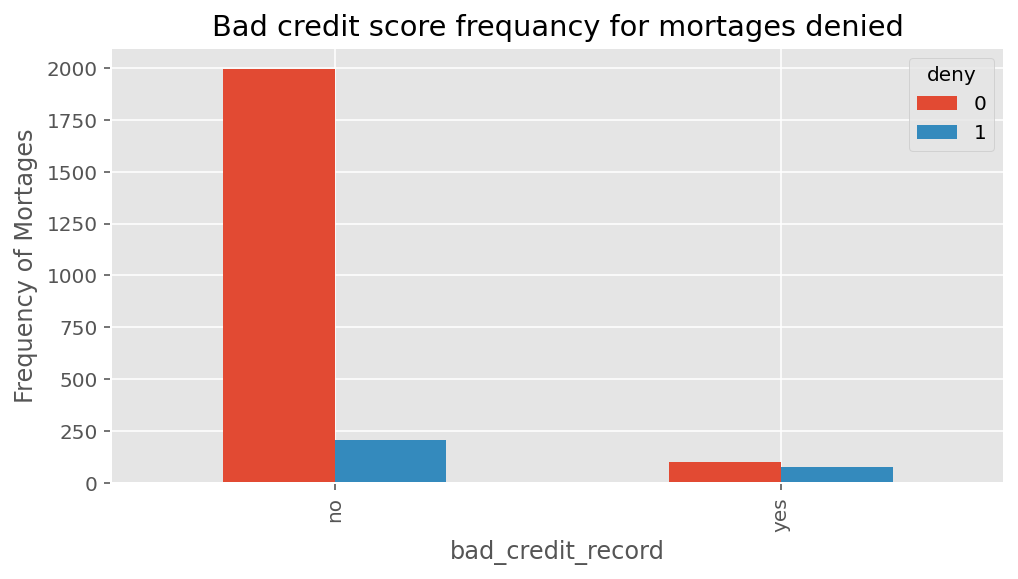

In [17]:
pd.crosstab(df.bad_credit_record,df.deny).plot(kind = 'bar');
plt.title('Bad credit score frequancy for mortages denied')
plt.xlabel('bad_credit_record')
plt.ylabel('Frequency of Mortages')

something..

In [18]:
predictors.append('bad_credit_record')

In [19]:
df.groupby('denied_mort_insur').mean()

,debt_pymt_income_ratio,house_expen_income_ratio,loan_size_prop_value_ratio,cons_cred_score,mort_cred_score,unemp_rate_app_industry,unit_condo,deny
denied_mort_insur,,,,,,,,
no,0.330133,0.255067,0.734674,2.104202,1.717410,3.770712,0.288593,0.103345
yes,0.363894,0.268917,0.888475,2.708333,1.895833,3.958333,0.270833,0.916667


Text(0, 0.5, 'Frequency of Mortages')

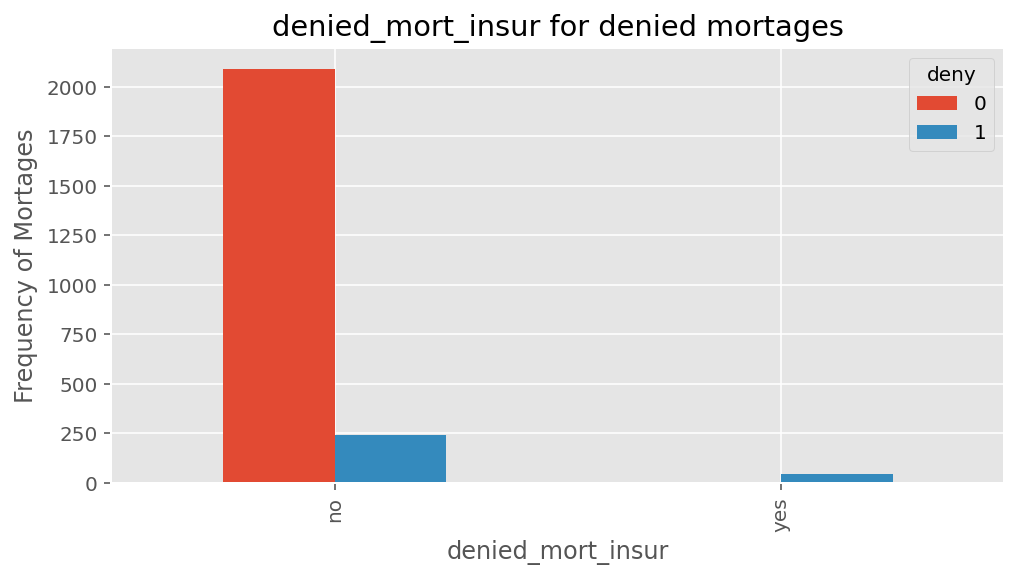

In [20]:
pd.crosstab(df.denied_mort_insur,df.deny).plot(kind='bar');
plt.title('denied_mort_insur for denied mortages')
plt.xlabel('denied_mort_insur')
plt.ylabel('Frequency of Mortages')

The frequency of mortages depends a great deal on the public credit record. Thus, the public bad credit record can be a good predictor of the outcome variable.

In [21]:
predictors.append('denied_mort_insur')

In [22]:
df.groupby('self_emp').mean()

,debt_pymt_income_ratio,house_expen_income_ratio,loan_size_prop_value_ratio,cons_cred_score,mort_cred_score,unemp_rate_app_industry,unit_condo,deny
self_emp,,,,,,,,
no,0.329407,0.255845,0.741451,2.126010,1.733714,3.670043,0.293390,0.113647
yes,0.341492,0.251555,0.709875,2.043321,1.624549,4.567509,0.249097,0.166065


Text(0, 0.5, 'Frequency of Mortages')

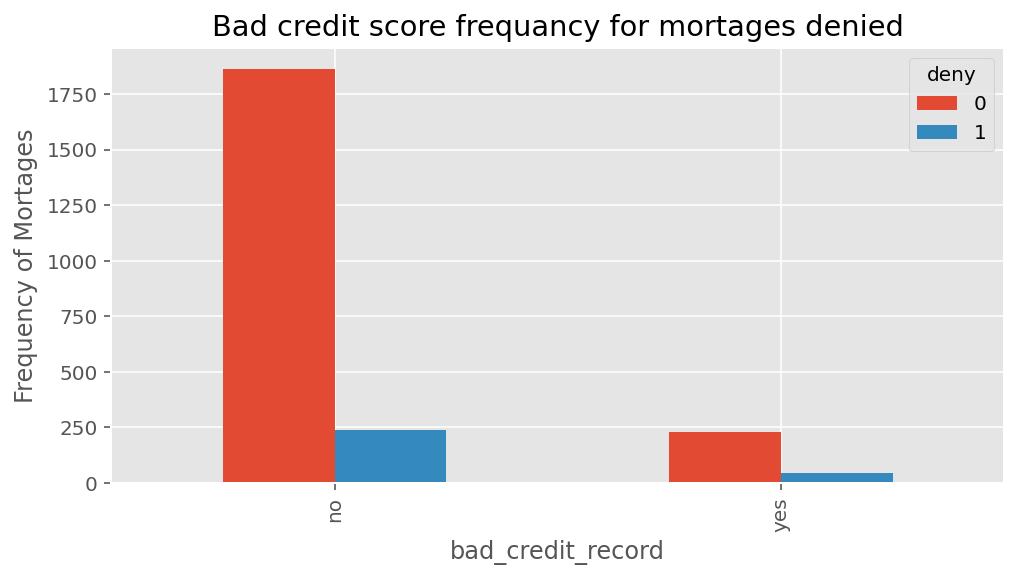

In [24]:
pd.crosstab(df.self_emp,df.deny).plot(kind='bar');
plt.title('Bad credit score frequancy for mortages denied')
plt.xlabel('bad_credit_record')
plt.ylabel('Frequency of Mortages')

The self employed status seem a strong predictor for the outcome variable.

In [25]:
predictors.append('self_emp')

In [26]:
df.groupby('single').mean()

,debt_pymt_income_ratio,house_expen_income_ratio,loan_size_prop_value_ratio,cons_cred_score,mort_cred_score,unemp_rate_app_industry,unit_condo,deny
single,,,,,,,,
no,0.328133,0.250691,0.731265,2.097645,1.648892,3.850208,0.179363,0.099723
yes,0.334949,0.262527,0.747821,2.145299,1.832265,3.657692,0.456197,0.150641


Text(0, 0.5, 'Frequency of Mortages')

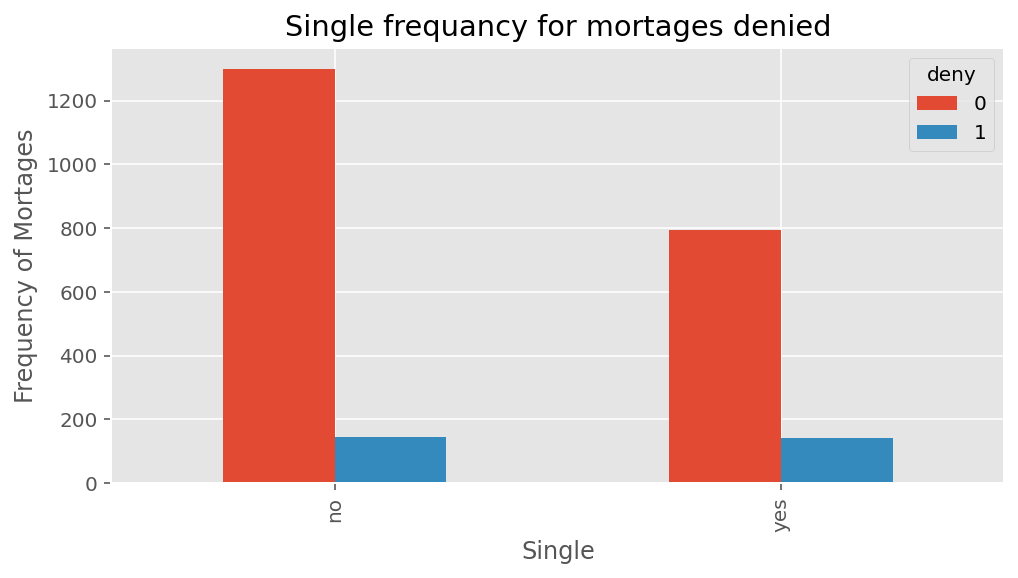

In [27]:
pd.crosstab(df.single,df.deny).plot(kind='bar');
plt.title('Single frequancy for mortages denied')
plt.xlabel('Single')
plt.ylabel('Frequency of Mortages')

The single status does not seem a strong predictor for the outcome variable.

In [28]:
df.groupby('unit_condo').mean()

,debt_pymt_income_ratio,house_expen_income_ratio,loan_size_prop_value_ratio,cons_cred_score,mort_cred_score,unemp_rate_app_industry,deny
unit_condo,,,,,,,
0,0.331663,0.258178,0.731526,2.062574,1.690083,3.904309,0.111570
1,0.328715,0.248354,0.753208,2.249271,1.797376,3.453936,0.139942


Text(0, 0.5, 'Frequency of Mortages')

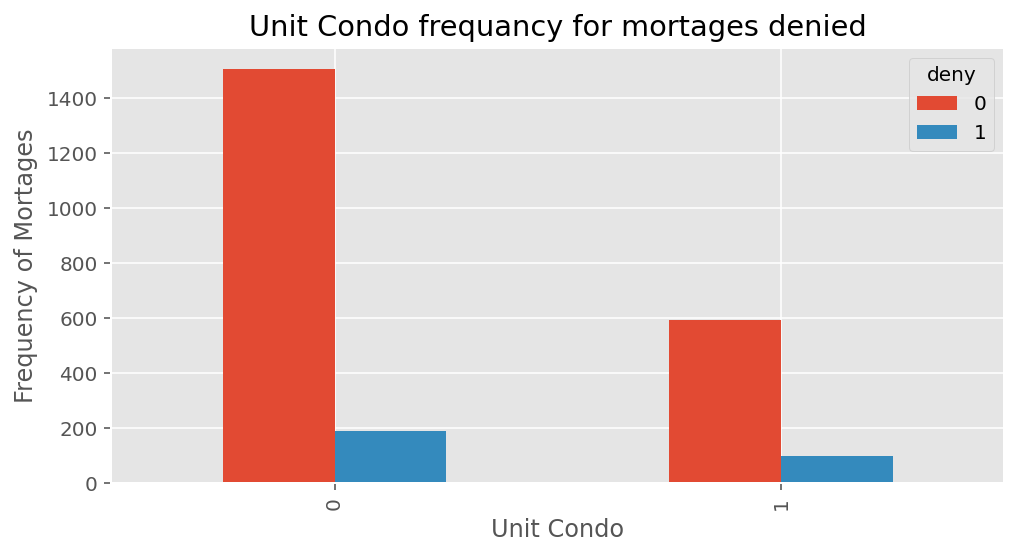

In [29]:
pd.crosstab(df.unit_condo,df.deny).plot(kind='bar');
plt.title('Unit Condo frequancy for mortages denied')
plt.xlabel('Unit Condo')
plt.ylabel('Frequency of Mortages')

The unit being a condo can potentially be a good predictor, but it is not so clear.

In [30]:
df.groupby('black').mean()

,debt_pymt_income_ratio,house_expen_income_ratio,loan_size_prop_value_ratio,cons_cred_score,mort_cred_score,unemp_rate_app_industry,unit_condo,deny
black,,,,,,,,
no,0.327463,0.253532,0.725971,1.966193,1.694757,3.829201,0.254287,0.092602
yes,0.350989,0.266266,0.808848,3.020649,1.879056,3.445133,0.492625,0.283186


Text(0, 0.5, 'Frequency of Mortages')

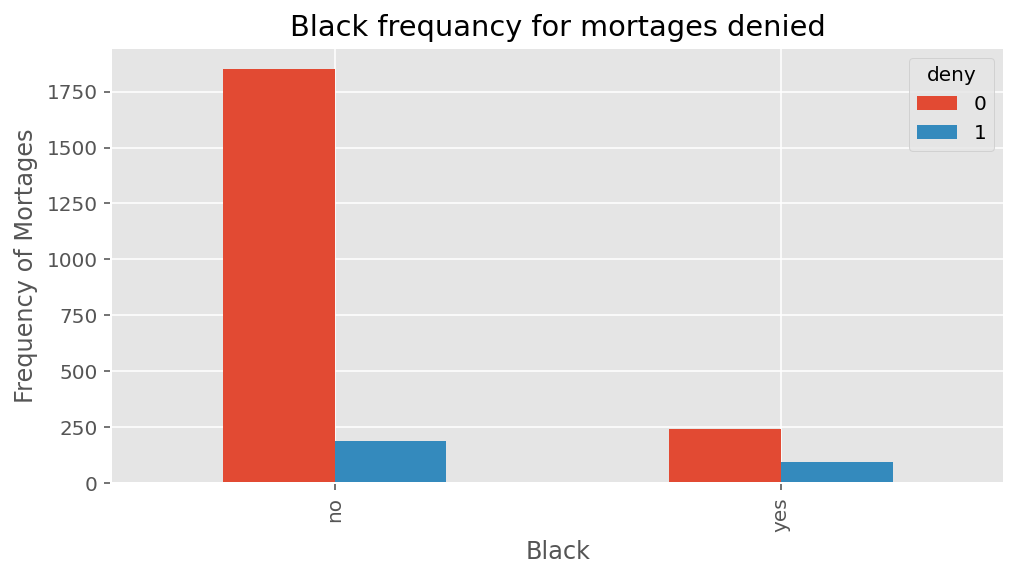

In [31]:
pd.crosstab(df.black,df.deny).plot(kind='bar');
plt.title('Black frequancy for mortages denied')
plt.xlabel('Black')
plt.ylabel('Frequency of Mortages')

The black status does not seem a strong predictor for the outcome variable.

In [32]:
predictors

['cons_cred_score',
 'loan_size_prop_value_ratio',
 'bad_credit_record',
 'denied_mort_insur',
 'self_emp']

### Over-sampling using SMOTE

Considering the imbalance class in the response we need to find a way to make the 2 outcomes somewhat even. With our training data created, I’ll up-sample the no-deny using the SMOTE algorithm(Synthetic Minority Oversampling Technique). At a high level, SMOTE: 

- Works by creating synthetic samples from the minor class (no-subscription) instead of creating copies.
- Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observations.

In [33]:
#first we replace 'no' with zero and 'yes' with 1
df.bad_credit_record.replace(["no", "yes"], [0, 1], inplace = True)
df.denied_mort_insur.replace(["no", "yes"], [0, 1], inplace = True)
df.self_emp.replace(["no", "yes"], [0, 1], inplace = True)
df.single.replace(["no", "yes"], [0, 1], inplace = True)
df.black.replace(["no", "yes"], [0, 1], inplace = True)

In [35]:
from imblearn.over_sampling import SMOTE

X = df.loc[:, predictors]
y = df.loc[:, 'deny']

In [36]:
from sklearn.model_selection import train_test_split
os = SMOTE(random_state = 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

columns = X_train.columns

os_data_X, os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data = os_data_X,columns=columns )
os_data_y= pd.DataFrame(data = os_data_y,columns=['deny'])

# we can Check the numbers of our data
print("length of oversampled data is ", len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['deny'] == 0]))
print("Number of subscription",len(os_data_y[os_data_y['deny'] == 1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['deny'] == 0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['deny'] == 1])/len(os_data_X))


length of oversampled data is  2926
Number of no subscription in oversampled data 1463
Number of subscription 1463
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


In [37]:
#chequing over_sampling results
os_data_y.deny.value_counts()

1    1463
0    1463
Name: deny, dtype: int64

In [38]:
X = os_data_X[predictors]
y = os_data_y['deny']

### Logistic Regression Model Fitting

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [99]:
# # Feature Scaling
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()

In [100]:
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

In [101]:
#logreg = LogisticRegression()
#logreg.fit(X_train, y_train)

In [102]:
#y_pred = logreg.predict(X_test)
#print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

In [103]:
# Making the Confusion Matrix
#from sklearn.metrics import confusion_matrix
#cm = confusion_matrix(y_test, y_pred)

In [104]:
# Plotting the Confusion Matrix
#sns.heatmap(cm, annot = True, cmap='Blues', fmt='g')
#plt.title("Confusion Matrix\n")
#plt.show();

In [40]:
X_train

,cons_cred_score,loan_size_prop_value_ratio,bad_credit_record,denied_mort_insur,self_emp
2436,6.0,0.896374,1,1,0
1888,5.0,0.901793,0,0,0
1571,1.0,0.833333,0,0,0
2512,5.0,0.845751,0,0,0
1334,2.0,0.800000,0,0,0
...,...,...,...,...,...
763,3.0,0.800000,0,0,0
835,4.0,0.315789,0,0,0
1653,1.0,0.739394,0,0,0
2607,1.0,0.739642,0,0,1


# Univariate feature selection and random forest classification
In univariate feature selection, we will use SelectKBest that removes all but the k highest scoring features.This is according to the sklearn documentation. 

http://scikitlearn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest

In [48]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
# find best scored 5 features
select_feature = SelectKBest(chi2, k=5).fit(X_train, y_train)

In [49]:
print('Score list:', select_feature.scores_)
print('Feature list:', X_train.columns)

Score list: [417.02575825   5.83535716 145.23139552 134.51467035   1.99736972]
Feature list: Index(['cons_cred_score', 'loan_size_prop_value_ratio', 'bad_credit_record',
       'denied_mort_insur', 'self_emp'],
      dtype='object')


Accuracy is:  0.7218430034129693


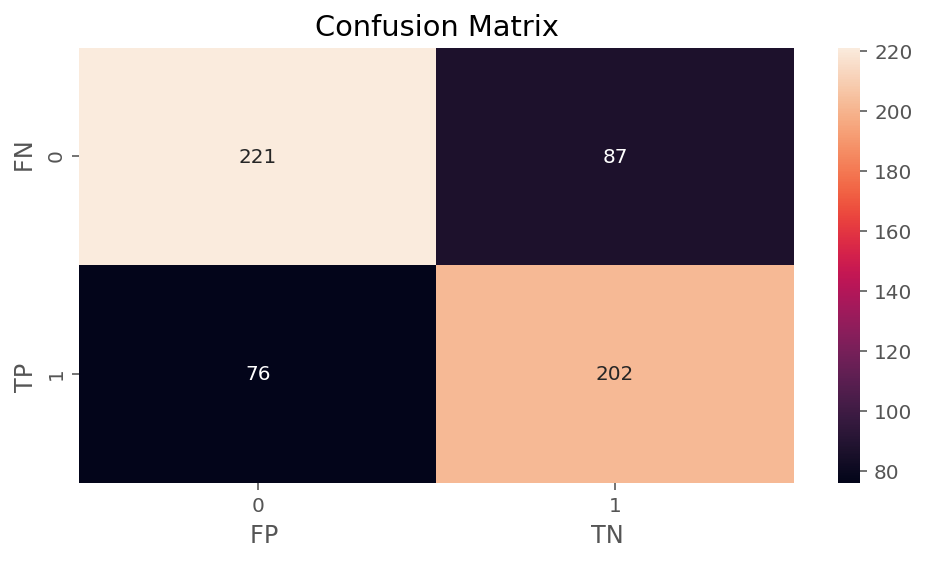

In [69]:
X_train_2 = select_feature.transform(X_train)
X_test_2 = select_feature.transform(X_test)
#random forest classifier with n_estimators=10 (default)
clf_rf_2 = RandomForestClassifier()      
clr_rf_2 = clf_rf_2.fit(X_train_2,y_train)
ac_2 = accuracy_score(y_test,clf_rf_2.predict(X_test_2))
print('Accuracy is: ',ac_2)
cm_2 = confusion_matrix(y_test,clf_rf_2.predict(X_test_2))
sns.heatmap(cm_2,annot=True,fmt="d")
plt.title("Confusion Matrix")
plt.ylabel('TP                         FN')
plt.xlabel('FP                                         TN')
plt.show();

## 3) Recursive feature elimination (RFE) with random forest.
http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html 

It uses one of the classification methods (random forest), assign weights to each of features. Whose absolute weights are the smallest are pruned from the current set of features. That procedure is recursively repeated on the pruned set until the we get the desired number of features.

In [70]:
from sklearn.feature_selection import RFE
clf_rf_3 = RandomForestClassifier()      
rfe = RFE(estimator=clf_rf_3, n_features_to_select = 5, step = 1)
rfe = rfe.fit(X_train, y_train)

In [71]:
print('Chosen best 5 feature by rfe:',X_train.columns[rfe.support_])

Chosen best 5 feature by rfe: Index(['cons_cred_score', 'loan_size_prop_value_ratio', 'bad_credit_record',
       'denied_mort_insur', 'self_emp'],
      dtype='object')


Chosen 5 best features by rfe: 'cons_cred_score', 'loan_size_prop_value_ratio', 'bad_credit_record','denied_mort_insur'. 'self_emp'.They are exactly similar with previous (selectkBest) method. Therefore we do not need to calculate accuracy again.

We chose to select the 5 best features on arbitrairy bases so lets look at how many features do we need to provide the best accuracy using rfecv method.

# Recursive feature elimination with cross validation and random forest classification.

http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html Now we will not only find best features but we also find how many features do we need for best accuracy.

In [72]:
from sklearn.feature_selection import RFECV

# The "accuracy" scoring is proportional to the number of correct classifications
clf_rf_4 = RandomForestClassifier() 
rfecv = RFECV(estimator=clf_rf_4, step=1, cv = 10,scoring='accuracy')   #5-fold cross-validation
rfecv = rfecv.fit(X_train, y_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train.columns[rfecv.support_])

Optimal number of features : 5
Best features : Index(['cons_cred_score', 'loan_size_prop_value_ratio', 'bad_credit_record',
       'denied_mort_insur', 'self_emp'],
      dtype='object')


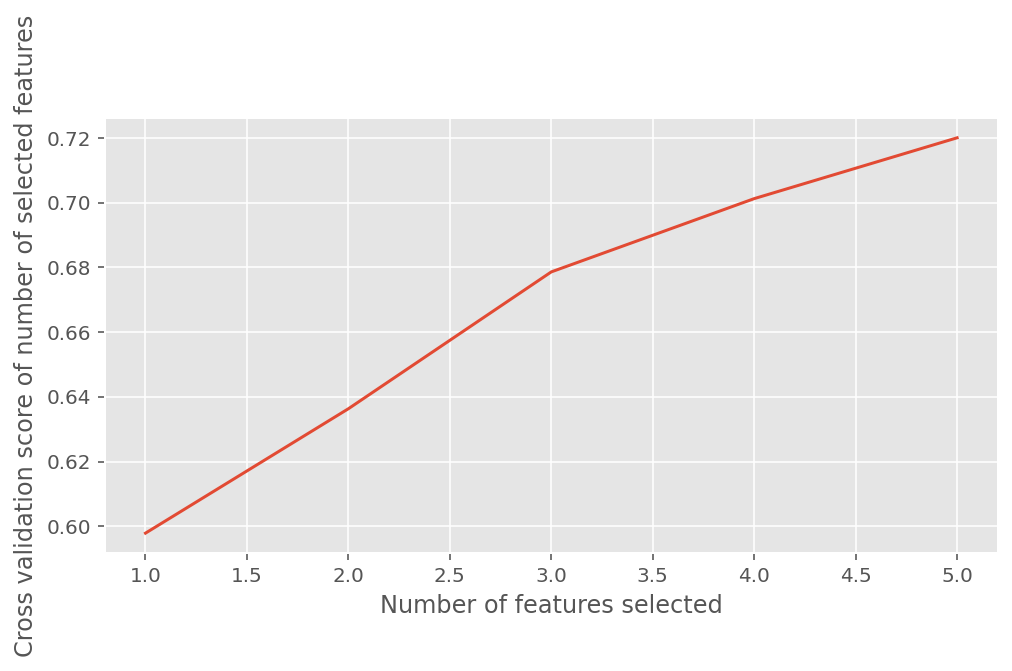

In [73]:
# Plot number of features VS. cross-validation scores
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

# Tree based feature selection and random forest classification.

http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html 

In random forest classification method there is a feature importances attributes that is the feature importances. To use feature_importance method, in training data there should not be correlated features. Random forest choose randomly at each iteration, therefore sequence of feature importance list can change.

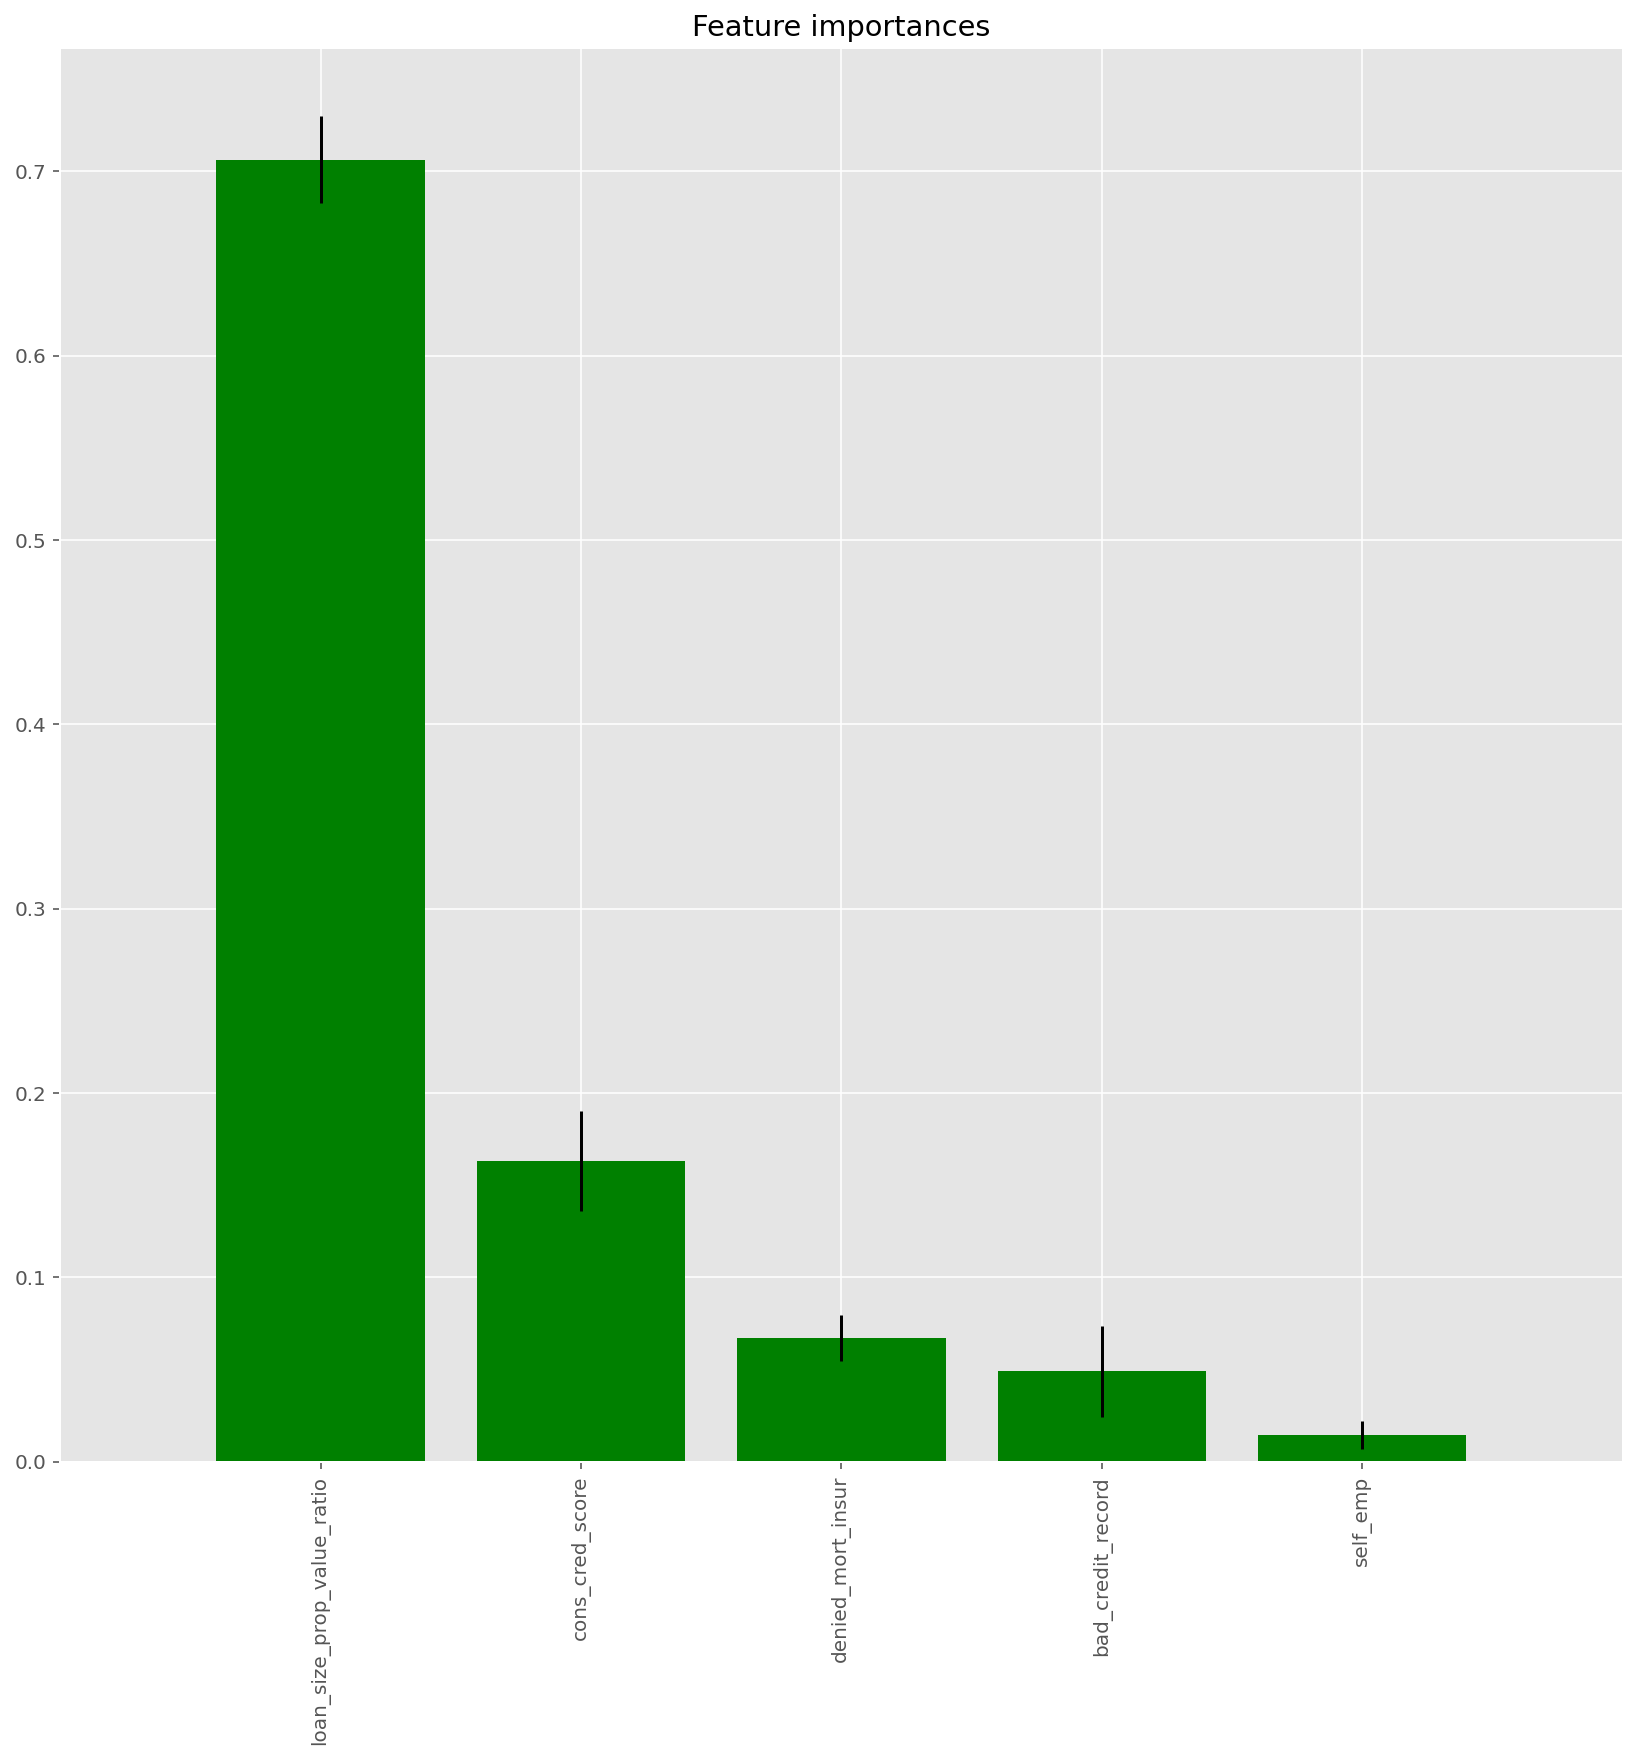

Feature ranking:
1. feature 1 (0.706374)
2. feature 0 (0.163162)
3. feature 3 (0.067027)
4. feature 2 (0.049029)
5. feature 4 (0.014408)


In [74]:
clf_rf_5 = RandomForestClassifier()   

clr_rf_5 = clf_rf_5.fit(X_train,y_train)

importances = clr_rf_5.feature_importances_

std = np.std([tree.feature_importances_ for tree in clf_rf_5.estimators_],
             axis=0)

indices = np.argsort(importances)[::-1]


# Plot the feature importances of the forest

plt.figure(1, figsize=(14, 13))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices],rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show();


# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))